In [1]:

import numpy as np
import random


# Bring in PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
# Most of the examples have typing on the signatures for readability
from typing import  Dict,Tuple



from Bio.PDB import PDBList
from Bio.PDB.MMCIFParser import MMCIFParser


#phi and psi
from Bio.PDB import PICIO, PDBIO
from Bio import PDB

from Bio.PDB import PDBList
import pandas as pd

from transformers import BertModel, BertTokenizer
import re


import pickle



/home/mihriban/gf_transformer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False ) # change model and tokenizer to t5
model_embedd = BertModel.from_pretrained("Rostlab/prot_bert")
model_embedd = model_embedd.to(device)


In [4]:
angles = torch.load('new_training/angles.pt')
## remove this when your code is complete!!
angles = angles[:200,:,:].to(device)
#phi_angles = angles[:100,0,:]
#psi_angles = angles[:,1,:]

print(angles.size())
#print(phi_angles.size())
print(angles[2,:,:])

torch.Size([200, 2, 131])
tensor([[-158.1443,  -60.6775,  -61.0688,  -93.8929,  143.1417,  139.0906,
         -108.8788,  109.1569,  -70.8888,  -31.9908,  -32.2570,  -30.1556,
          -35.4733,  -27.4845,  -64.6790,  -28.7246,  -68.8967,  -33.3927,
          -64.2345,  -22.0535,  -28.1096,  -58.9587,  -55.7786,  -47.3196,
          -55.4300,  -29.8243,  -50.2119,  -42.0759,  -54.2975,  -65.0425,
          -64.2879,  -74.5227,   43.2627,   63.0199,  -53.7839,  -69.4932,
          -43.8047,  -64.2730,  -59.7437,  -61.2879,  -60.4110,  -60.9323,
          -64.4382,  -54.8045,  -41.6482,  -52.1125,  -44.6199,  -47.6718,
          -40.1522,  -51.5146,  -28.9987,  -34.3184,  -64.2064,  -35.0731,
          173.8537,  -49.2592,   48.9582,   32.6867,  -79.0367,  112.1066,
          -16.4187,  161.8003, -165.7947,  -38.2062,  -25.1589,  -68.5228,
          -41.9511,  -64.1659,  -49.8205,  -52.1241,  -16.7364,  -55.6295,
          -42.5034,  -56.1115,  -58.6457,  -53.2423,  -58.7762,  -27.6619,

In [5]:
embeddings = torch.load('training/embeddings.pt')
embeddings = embeddings[:200,:,:].to(device)
print(embeddings.size())

torch.Size([200, 131, 1024])


In [6]:

# Ensure this matches the file path used when saving
with open('training/sequences.pkl', 'rb') as f:
        sequences = pickle.load(f)
print(sequences)
sequences = sequences[:200]
print(len(sequences)) #here len is not the length of sequence, but number of sequences in total

[['P', 'T', 'V', 'E', 'Y', 'L', 'N', 'Y', 'E', 'T', 'L', 'D', 'D', 'Q', 'G', 'W', 'D', 'M', 'D', 'D', 'D', 'D', 'L', 'F', 'E', 'K', 'A', 'A', 'D', 'A', 'G', 'L', 'D', 'G', 'E', 'D', 'Y', 'G', 'T', 'M', 'E', 'V', 'A', 'E', 'G', 'E', 'Y', 'I', 'L', 'E', 'A', 'A', 'E', 'A', 'Q', 'G', 'Y', 'D', 'W', 'P', 'F', 'S', 'C', 'R', 'A', 'G', 'A', 'C', 'A', 'N', 'C', 'A', 'S', 'I', 'V', 'K', 'E', 'G', 'E', 'I', 'D', 'M', 'D', 'M', 'Q', 'Q', 'I', 'L', 'S', 'D', 'E', 'E', 'V', 'E', 'E', 'K', 'D', 'V', 'R', 'L', 'T', 'C', 'I', 'G', 'S', 'P', 'A', 'A', 'D', 'E', 'V', 'K', 'I', 'V', 'Y', 'N', 'A', 'X', 'H', 'L', 'D', 'Y', 'L', 'Q', 'N', 'R', 'V', 'I', 'X'], ['G', 'S', 'K', 'T', 'K', 'A', 'P', 'S', 'I', 'S', 'I', 'P', 'H', 'D', 'F', 'R', 'Q', 'V', 'S', 'A', 'I', 'I', 'D', 'V', 'D', 'I', 'V', 'P', 'E', 'T', 'H', 'R', 'R', 'V', 'R', 'L', 'L', 'K', 'H', 'G', 'S', 'D', 'K', 'P', 'L', 'G', 'F', 'Y', 'I', 'R', 'D', 'G', 'T', 'S', 'V', 'R', 'V', 'T', 'A', 'S', 'G', 'L', 'E', 'K', 'Q', 'P', 'G', 'I', 'F', 'I', '

In [7]:
df = pd.read_csv('training/dataframe.csv')


Masking

In [8]:

class SelfAttention(nn.Module):
    def __init__(self, embed_dim: int):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.w_q = nn.Parameter(torch.randn(embed_dim, embed_dim))
        self.w_k = nn.Parameter(torch.randn(embed_dim, embed_dim))
        self.w_v = nn.Parameter(torch.randn(embed_dim, embed_dim))

    def forward(self, embeddings_prot_bert: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        Q = torch.matmul(embeddings_prot_bert, self.w_q)
        K = torch.matmul(embeddings_prot_bert, self.w_k)
        V = torch.matmul(embeddings_prot_bert, self.w_v)

        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(K.size(-1))
        scores = scores.masked_fill(mask == 0, float('-inf')) #if masked, the value is going as low as possible to avoid being scored

        attn = torch.softmax(scores, dim=-1)
        attention_output = torch.matmul(attn, V)

        return attention_output

class SelfAttention_after_train(nn.Module):
    def __init__(self, embed_dim: int):
        super(SelfAttention_after_train, self).__init__()
        self.embed_dim = embed_dim
        self.w_q = nn.Parameter(torch.randn(embed_dim, embed_dim))
        self.w_k = nn.Parameter(torch.randn(embed_dim, embed_dim))
        self.w_v = nn.Parameter(torch.randn(embed_dim, embed_dim))

    def forward(self, embeddings_prot_bert: torch.Tensor) -> torch.Tensor:
        Q = torch.matmul(embeddings_prot_bert, self.w_q)
        K = torch.matmul(embeddings_prot_bert, self.w_k)
        V = torch.matmul(embeddings_prot_bert, self.w_v)

        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(K.size(-1))
        
        attn = torch.softmax(scores, dim=-1)
        attention_output = torch.matmul(attn, V)

        return attention_output


class TransformerModel(nn.Module):
    def __init__(self, embed_dim: int, feed_forward_dim1: int, feed_forward_dim2: int, output_dim: int = 2, dropout_rate: float = 0.1):
        super(TransformerModel, self).__init__()
        self.self_attention = SelfAttention(embed_dim)
        self.self_attention_after_train = SelfAttention_after_train(embed_dim)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.feed_forward = nn.Sequential(  
            nn.Linear(embed_dim, feed_forward_dim1),
            nn.GELU(),
            self.dropout,
            nn.Linear(feed_forward_dim1, feed_forward_dim2),
            nn.GELU(),
            self.dropout,
            nn.Linear(feed_forward_dim2, output_dim)
        )

    def forward(self, embeddings: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        attention_output = self.self_attention(embeddings, mask)
        normalized_attention_output = self.layer_norm1(attention_output)
        ff_output = self.feed_forward(normalized_attention_output)
        output = self.layer_norm2(ff_output)
        return ff_output
    
    def forward_after_train(self, embeddings: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        attention_output = self.self_attention_after_train(embeddings)
        normalized_attention_output = self.layer_norm1(attention_output)
        ff_output = self.feed_forward(normalized_attention_output)
        output = self.layer_norm2(ff_output)
        return ff_output


def create_mask(indices ): #lengths can be df['len']
    mask = torch.arange(131) < lengths[indices] #maybe we need to unsqueeze this
    mask = mask.to(device)
    return mask
           #[0,1,...130]

class AngularLoss(nn.Module):
    def __init__(self):
        super(AngularLoss, self).__init__()

    def forward(self,idx, predicted_angles, angles_tensor):

        predicted_angles_phi, predicted_angles_psi = predicted_angles[:, 0], predicted_angles[:, 1]
        angles_tensor_phi, angles_tensor_psi = angles_tensor[:,0, idx], angles_tensor[:, 1,idx]
        
        predicted_angles_phi = (predicted_angles_phi + torch.pi) % (2 * torch.pi) - torch.pi
        angles_tensor_phi = (angles_tensor_phi + torch.pi) % (2 * torch.pi) - torch.pi
        predicted_angles_psi = (predicted_angles_psi + torch.pi) % (2 * torch.pi) - torch.pi
        angles_tensor_psi = (angles_tensor_psi + torch.pi) % (2 * torch.pi) - torch.pi

        difference_phi = torch.abs(predicted_angles_phi - angles_tensor_phi)*create_mask(indices= idx)
        loss_phi = torch.mean(torch.min(difference_phi, 2 * torch.pi - difference_phi)) / create_mask(indices= idx).sum()

        difference_psi = torch.abs(predicted_angles_psi - angles_tensor_psi)*create_mask(indices= idx)
        loss_psi = torch.mean(torch.min(difference_psi, 2 * torch.pi - difference_psi))/ create_mask(indices= idx).sum()

        loss = loss_phi + loss_psi
        #print(loss)
        return loss

class TransformerTrainer:
    def __init__(self, model: nn.Module, criterion: nn.Module, num_epochs: int, sequence: torch.Tensor, angles: torch.Tensor):
        self.model = model
        self.criterion = criterion
        self.num_epochs = num_epochs
        self.sequence = sequence
        self.angles_tensor = angles
        self.optimizer = optim.AdamW(model.parameters(), lr=0.001)
        #self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.1)

    def train(self):
        loss_list = []
        val_loss = []
        indices = np.arange(0, len(self.sequence[:,0,0])) # shuffling the indices around, maybe we can do it after the epoch for more shuffling
        random.shuffle(indices)
        

        #now im going to include validation
        val_indices = indices[int(0.8 * len(indices)):int(0.9 * len(indices))]

        for epoch in range(self.num_epochs):
          for idx in indices[:int(0.8*len(self.sequence[:,0,0]))]: #im taking 80 percent of the dataset
            self.optimizer.zero_grad()
            predictions = self.model.forward(self.sequence[idx,:,:], create_mask(indices = idx))[:, :len(self.angles_tensor[:,:,idx])]
            #loss = CustomLoss()
            #loss.forward(torch.tensor(predictions, requires_grad=True), self.angles_tensor)
            loss = self.criterion(idx,predictions.squeeze(), self.angles_tensor)
            loss.backward(retain_graph=True)
            self.optimizer.step()
            #self.scheduler.step()
            loss_list.append(loss.item())

          #validation loop
          self.model.eval()
           
          with torch.no_grad():
              for idx_val in val_indices:
                mask = create_mask(idx_val)
                predictions = self.model(self.sequence[idx,:,:], mask)[:, :len(self.angles_tensor[:,:,idx])]
                loss = self.criterion(idx, predictions.squeeze(), self.angles_tensor)
                val_loss.append(loss.item())


          #print(f"Epoch {epoch + 1}/{self.num_epochs}, Loss: {loss.item()}")
          #torch.save(self.model.state_dict(), 'model_postraining.pt')
          print(f"Epoch {epoch + 1}/{self.num_epochs}, Training Loss: {loss_list[-1]}, Validation Loss: {val_loss[-1]}")

        return val_loss
        #return loss

In [9]:
#source_dir = '/content/map'

#tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
# Initialize and train transformer model
feed_forward_dim1 = 512
feed_forward_dim2 = 256
feed_forward_dim3 = 128
num_epochs = 200
dropout_rate = 0.1
model = TransformerModel(embed_dim=1024, feed_forward_dim1=feed_forward_dim1, feed_forward_dim2= feed_forward_dim2, dropout_rate = dropout_rate)
model = model.to(device)
criterion = AngularLoss()

N= 130
D = 1024
indices = np.arange(0, len(sequences))
random.shuffle(indices) # shuffling data

#for i in indices: # we can replace this with something better once we get all the files
#  angles_tensor = (angles[i,:,:].T)*(np.pi/180)
#  #mask = create_mask(torch.tensor([130]), 130)
#  trainer = TransformerTrainer(model, criterion, num_epochs, embeddings[i,:,:] , angles_tensor)#, mask)
#  print(i)
#  trainer.train()


lengths = torch.tensor(df['len'].values)
print(lengths.shape)
angles_tensor = (angles.T)*(np.pi/180)
trainer = TransformerTrainer(model, criterion, num_epochs, embeddings , angles_tensor)#, mask)
loss = trainer.train()

torch.Size([1723])


/tmp/ipykernel_202908/4247984530.py:29: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  angles_tensor = (angles.T)*(np.pi/180)


Epoch 1/200, Training Loss: 0.01599356345832348, Validation Loss: 0.016229992732405663
Epoch 2/200, Training Loss: 0.014808873645961285, Validation Loss: 0.014698654413223267
Epoch 3/200, Training Loss: 0.014750147238373756, Validation Loss: 0.014459887519478798
Epoch 4/200, Training Loss: 0.014688383787870407, Validation Loss: 0.014185808598995209
Epoch 5/200, Training Loss: 0.013207970187067986, Validation Loss: 0.01286608912050724
Epoch 6/200, Training Loss: 0.011936371214687824, Validation Loss: 0.01141673419624567
Epoch 7/200, Training Loss: 0.01231810636818409, Validation Loss: 0.012054023332893848
Epoch 8/200, Training Loss: 0.012216122820973396, Validation Loss: 0.012008757330477238
Epoch 9/200, Training Loss: 0.011556173674762249, Validation Loss: 0.011179236695170403
Epoch 10/200, Training Loss: 0.01142178289592266, Validation Loss: 0.011349206790328026
Epoch 11/200, Training Loss: 0.011768799275159836, Validation Loss: 0.011417660862207413
Epoch 12/200, Training Loss: 0.0114

In [10]:
import matplotlib.pyplot as plt

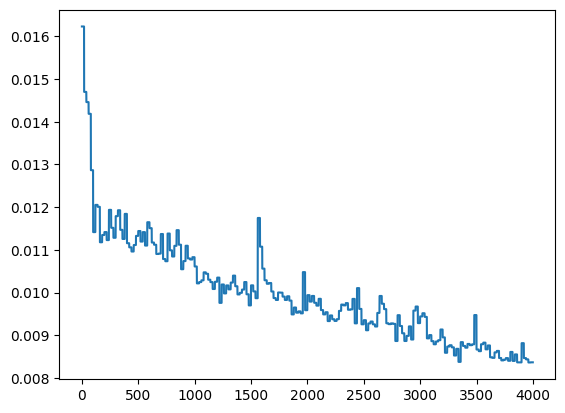

In [11]:
plt.plot(loss)

In [12]:
lengths[lengths == 90][0]

tensor(90)

In [20]:
n = 2
predicted_angles2 = model.forward(embeddings[n,:,:], create_mask(indices = n))[:lengths[n],:]#embedding, tensor, what attention

#predicted_angles2
angles_new2 =predicted_angles2.T*(180/np.pi)
angles_new2

tensor([[ 143.6077,  148.1842,  143.7669,  143.3656,  144.0147,  143.2904,
          142.3814,  141.3569,  143.6023,  -44.7786,  -44.7676,  -52.5824,
          -52.6166,  -44.7796,  -44.7818,  -52.9769,  -52.9848,  -44.7687,
          -44.7691,  -48.6014,  -52.9891,  -44.7693,  -46.4842,  -47.1541,
          -44.7691,  -44.6142,  -40.9671,  -41.2099,  -51.1139,  -44.3936,
          -52.7062,  -51.3499,  -52.3863,  -53.0003,  -44.7789,  -52.9901,
          -52.7324,  -44.7887,  -52.5381,  -51.1543,  -46.7829,  -50.9451,
          -52.6751,  -44.8527,  -47.5427,  -52.9751,  -44.9484,  -44.7746,
          -44.8520,  -52.9900,  -44.7771,  -44.7691,  -49.9174,  -45.3372,
          -44.7689,  -44.7692,  -44.7739,  -44.7828,  118.4824,  140.0055,
          -44.7246,  139.9397,  143.9080,  -52.9561,  -44.8230,  -46.5827,
          -44.7775,  -52.2847,  -44.7704,  -52.8055,  -52.9509,  -52.9817,
          -48.1328,  -52.8736,  -52.1692,  -44.8530,  -52.2250,  -52.9883,
          -52.0579,  -50.

In [13]:
n = 2

angles_tensor = angles[n,:,:].T*(np.pi/180)

#print(np.shape(embeddings[:, :len(angles_tensor),SelfAttention_after_train]))
predicted_angles = model.forward_after_train(embeddings[n,:,:], create_mask(indices = n))[:lengths[n],:]#embedding, tensor, what attention

predicted_angles

tensor([[-11.1268,  29.4106],
        [-22.3551,  46.2048],
        [-22.2233,  46.1421],
        [-21.7332,  45.7834],
        [-22.3298,  46.2104],
        [-21.7224,  45.7808],
        [-20.3515,  44.7051],
        [ -9.2905,  31.3742],
        [-10.4119,  29.4318],
        [-22.5777,  46.3945],
        [-16.6400,  41.2456],
        [-22.0679,  46.0294],
        [-13.2142,  33.9644],
        [ -8.8652,  30.5979],
        [ -9.0213,  30.8989],
        [-19.1141,  38.2712],
        [-15.7660,  35.9007],
        [-21.6915,  45.7581],
        [ -8.8647,  30.5979],
        [-22.5782,  46.3948],
        [-22.4722,  46.3195],
        [-20.7949,  45.0844],
        [ -8.8760,  30.6068],
        [-20.5859,  39.3112],
        [ -8.8643,  30.5974],
        [ -8.8663,  30.5996],
        [-20.5514,  44.9035],
        [-12.8845,  33.8928],
        [ -8.8644,  30.5977],
        [ -9.1715,  30.8713],
        [ -8.8642,  30.5974],
        [ -8.8667,  30.6002],
        [-22.3152,  44.1143],
        [-

In [14]:
print(np.shape(predicted_angles))

torch.Size([128, 2])


In [15]:
angles_new =predicted_angles.T*(180/np.pi)
print(angles_new)
torch.save(angles_new,'predictions/predict_10.pt' )

tensor([[ -637.5187, -1280.8544, -1273.3024, -1245.2228, -1279.4037, -1244.6018,
         -1166.0576,  -532.3036,  -596.5562, -1293.6083,  -953.4009, -1264.4001,
          -757.1187,  -507.9410,  -516.8832, -1095.1566,  -903.3275, -1242.8318,
          -507.9098, -1293.6349, -1287.5596, -1191.4609,  -508.5598, -1179.4849,
          -507.8878,  -508.0025, -1177.5061,  -738.2263,  -507.8932,  -525.4874,
          -507.8786,  -508.0251, -1278.5641,  -622.2225, -1154.8054, -1244.8932,
          -511.4425,  -552.0670,  -577.8295,  -954.5439,  -507.8763,  -507.8852,
         -1291.5164,  -510.2192,  -508.5620,  -574.8886,  -603.2353,  -507.8763,
          -507.8769, -1242.0464, -1293.6307, -1286.1888,  -599.6096,  -992.6992,
         -1293.6302,  -509.6216, -1144.5452,  -508.5044,  -508.6167,  -507.9361,
          -957.4365,  -508.2281,  -904.5009,  -553.7895, -1292.4554,  -508.6885,
         -1287.3658,  -545.2056,  -604.9271,  -551.4965, -1235.0653,  -510.8117,
          -508.5910, -1101.9

In [16]:
(angles[2,:,:].T).size()
#angles_new.size()

torch.Size([131, 2])

In [17]:
sequences[n]

['G',
 'S',
 'S',
 'G',
 'S',
 'S',
 'G',
 'M',
 'S',
 'E',
 'V',
 'T',
 'R',
 'S',
 'L',
 'L',
 'Q',
 'R',
 'W',
 'G',
 'A',
 'S',
 'L',
 'R',
 'R',
 'G',
 'A',
 'D',
 'F',
 'D',
 'S',
 'W',
 'G',
 'Q',
 'L',
 'V',
 'E',
 'A',
 'I',
 'D',
 'E',
 'Y',
 'Q',
 'I',
 'L',
 'A',
 'R',
 'H',
 'L',
 'Q',
 'K',
 'E',
 'A',
 'Q',
 'A',
 'Q',
 'H',
 'N',
 'N',
 'S',
 'E',
 'F',
 'T',
 'E',
 'E',
 'Q',
 'K',
 'K',
 'T',
 'I',
 'G',
 'K',
 'I',
 'A',
 'T',
 'C',
 'L',
 'E',
 'L',
 'R',
 'S',
 'A',
 'A',
 'L',
 'Q',
 'S',
 'T',
 'Q',
 'S',
 'Q',
 'E',
 'E',
 'F',
 'K',
 'L',
 'E',
 'D',
 'L',
 'K',
 'K',
 'L',
 'E',
 'P',
 'I',
 'L',
 'K',
 'N',
 'I',
 'L',
 'T',
 'Y',
 'N',
 'K',
 'E',
 'F',
 'P',
 'F',
 'D',
 'V',
 'Q',
 'P',
 'I',
 'S',
 'G',
 'P',
 'S',
 'S',
 'G',
 'X']

In [18]:
np.shape(angles)

torch.Size([200, 2, 131])

In [19]:
# loading file
'''pdbl = PDBList()
cif_parser = MMCIFParser()
structure = cif_parser.get_structure("2fm4", r"C:\Users\sandr\OneDrive\Desktop\LCP_B project\PISCES data\extraction\small proteins\2fm4.cif") # getting structure
model0 = structure[0]

d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
 'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
 'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
 'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

sequence = []
for residue in model0["A"]:
    # for simplicity we can use X for heteroatoms (ions and water)
    sequence.append(d3to1.get(residue.get_resname(), 'X'))  #converts water and ions to X
print(''.join(sequence))'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 93-94: truncated \UXXXXXXXX escape (1555672542.py, line 16)

In [ ]:

'''structure.atom_to_internal_coordinates() # turns xyz coordinates into angles and bond lengths

chain:PDB.Chain.Chain = list(structure[0].get_chains())[0]#iterator of chains, turns it into list, [0] first chain

ic_chain: PDB.internal_coords.IC_Chain = chain.internal_coord #this access the internal chain coords of the chain object
#if you modify this, you will modify the orgiginal

d: Dict[Tuple[PDB.internal_coords.AtomKey,
              PDB.internal_coords.AtomKey,
              PDB.internal_coords.AtomKey,
              PDB.internal_coords.AtomKey],
        PDB.internal_coords.Dihedron] = ic_chain.dihedra

cnt = 0
phi_angles = {}
psi_angles = {}

print(len(sequence))

for key in d:
    if key[0].akl[3] == 'N' and key[1].akl[3] == 'CA' and key[2].akl[3] == 'C' and key[3].akl[3] == 'N':

        d[key].angle = angles_new[ 1, cnt].item()
        print(angles_new[1,cnt].item())
    elif key[0].akl[3] == 'CA' and key[1].akl[3] == 'C' and key[2].akl[3] == 'N' and key[3].akl[3] == 'CA':
        d[key].angle = angles_new[ 0, cnt].item()
        #print("psi calcukated")
        print(cnt)
        cnt += 1


structure.internal_to_atom_coordinates(verbose = False)
io = PDBIO() #this is to write a pdb file again
io.set_structure(structure)#set structure, the structure you want in the pdb file
io.save('2fm4_pred.pdb',  preserve_atom_numbering=True) #saves to a file, filename you a , true - preserves the original atom numbering


'''

In [ ]:
'''print(PDB.internal_coords.Dihedron)'''